# Introduction

<b style="color: red">To use this notebook, go to Runtime > Change Runtime Type and select GPU as the hardware accelerator.</b>

This is code to accompany my blog post building on Kenneth Li et al's paper Emergent World Representations. I found that the network actually learns a **linear** world model, but in terms of whether a cell contains a piece of **my colour** vs the **opponent's colour**. I demonstrate how to use and intervene with the linear probe I found, use the probe to start interpreting the model and studying circuits, and some starter code for neuron interpretability and activation patching

If you're new to mechanistic interpretability, check out [my blog post on getting started](https://neelnanda.io/getting-started). This notebook heavily uses my TransformerLens library, check out [the main tutorial for a better introduction](https://neelnanda.io/transformer-lens-demo).

Read the blog post here: https://neelnanda.io/othello

Look up unfamiliar terms here: https://neelnanda.io/glossary 

The paper: https://arxiv.org/pdf/2210.13382.pdf



## Setup (Don't Read This)

In [1]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEVELOPMENT_MODE = True
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install transformer_lens==1.2.1
    %pip install git+https://github.com/neelnanda-io/neel-plotly
    
    # PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
    # # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Jupyter notebook - intended for development only!


C:\Users\ALTjasonspeed\AppData\Local\Temp\ipykernel_27508\2822487226.py:21: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
C:\Users\ALTjasonspeed\AppData\Local\Temp\ipykernel_27508\2822487226.py:22: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


In [2]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "vscode"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: vscode


In [1]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

c:\Users\ALTjasonspeed\.conda\envs\othellogpt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [7]:
torch.set_grad_enabled(False)

Plotting helper functions:

In [8]:
from neel_plotly import line, scatter, imshow, histogram

# Othello GPT

<details><summary>I was in a massive rush when I made this codebase, so it's a bit of a mess, sorry! This Colab is an attempt to put a smiley face on the underlying shoggoth, but if you want more of the guts, here's an info dump</summary>

This codebase is a bit of a mess! This colab is an attempt to be a pretty mask on top of the shoggoth, but if it helps, here's an info dump I wrote for someone about interpreting this codebase:

Technical details:

-   Games are 60 moves, but the model can only take in 59. It's trained to predict the next move, so they give it the first 59 moves (0<=...<59) and evaluate the predictions for each next move (1<=...<60). There is no Beginning of Sequence token, and the model never tries to predict the first move of the game

-   This means that, while in Othello black plays first, here white plays "first" because first is actually second

-   You can get code to load the synthetic model (ie trained to play uniformly random legal moves) into TransformerLens here: [https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Othello\_GPT.ipynb](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Othello_GPT.ipynb) 
-   You can load in their synthetically generated games [from their Github](https://github.com/likenneth/othello_world) (there's a google drive link)
-   Their model has 8 layers, residual stream width 512, 8 heads per layer and 2048 neurons per layer.

-   The vocab size is 61. 0 is -100, which I *think *means pass, I just filtered out the rare games that include that move and ignore it. 1 to 60 (inclusive) means the board moves in lexicographic order (A0, A1, ..., A7, B0, ...) but *skipping *D3, D4, E3 and E4. These are at the center of the board and so can never be played, because Othello starts with them filled)

-   There's 3 ways to denote a board cell. I call them "int", "string" and "label" (which is terrible notation, sorry). 

-   "label" means the label for a board cell, \["A0", ..., "A7", ''', "H7"\] (I index at 0 not 1, sorry!). 
-   "int" means "part of the model vocabulary", so 1 means A0, we then count up but miss the center squares, so 27 is D2, 28 is D5, 33 is E2 and 34 is E5. 
-   "string" means "the input format of the OthelloBoardState class". These are integers (sorry!) from 0 to 63, and exactly correspond to labels A0, ..., H7, without skipping any center cells. OthelloBoardState is a class in data/othello.py that can play the Othello game and tell you the board state and valid moves (created by the authors, not me)
-   I have utility functions to\_int, to\_string, str\_to\_label and int\_to\_label in tl\_othello\_utils.py to do this

-   The embedding and unembedding are untied (ie, in contrast to most language models, the map W\_U from final residual to the logits is *not *the transpose of W\_E, the map from tokens to the initial residual. They're unrelated matrices)
-   tl\_othello\_utils.py is my utils file, with various functions to load games, etc. \`board\_seqs\_string\` and \`board\_seqs\_int\` are massive saved tensors with every move across all 4.5M synthetic games in both string and int format, these are 2.3GB so I haven't attached them lol. You can recreate them from the synthetic games they provide. It also provides a bunch of plotting functions to make nice othello board states, and some random other utilities
-   \`tl\_probing.py\` is my probe training file. But it was used to train a *second* probe, linear\_probe\_L4\_blank\_vs\_color\_v1.pth . This probe actually didn't work very well for analysing the model (despite getting great accuracy) and I don't know why - it was trained on layer 4, to do a binary classification on blank vs not blank, and on my color vs their color *conditional *on not being blank (ie not evaluated if blank). For some reason, the "this cell is my color" direction has a significant dot product with the "is blank" direction, and this makes it much worse for eg interpreting neurons. I don't know why!
-   \`tl\_scratch.py\` is where I did some initial exploration, including activation patching between different final moves
-   \`tl\_exploration.py\` is where I did my most recent exploration, verifying that the probe works, doing probe interventions (CTRL F for \`newly\_legal\`) and using the probe to interpret neurons

</details>


## Loading the model

This loads a conversion of the author's synthetic model checkpoint to TransformerLens format. See [this notebook](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Othello_GPT.ipynb) for how.

In [9]:
import transformer_lens.utils as utils
cfg = HookedTransformerConfig(
    n_layers = 8,
    d_model = 512,
    d_head = 64,
    n_heads = 8,
    d_mlp = 2048,
    d_vocab = 61,
    n_ctx = 59,
    act_fn="gelu",
    normalization_type="LNPre"
)
model = HookedTransformer(cfg)

In [10]:

sd = utils.download_file_from_hf("NeelNanda/Othello-GPT-Transformer-Lens", "synthetic_model.pth")
# champion_ship_sd = utils.download_file_from_hf("NeelNanda/Othello-GPT-Transformer-Lens", "championship_model.pth")
model.load_state_dict(sd)

<All keys matched successfully>

Code to load and convert one of the author's checkpoints to TransformerLens:

Testing code for the synthetic checkpoint giving the correct outputs

In [9]:
# An example input
sample_input = torch.tensor([[20, 19, 18, 10, 2, 1, 27, 3, 41, 42, 34, 12, 4, 40, 11, 29, 43, 13, 48, 56, 33, 39, 22, 44, 24, 5, 46, 6, 32, 36, 51, 58, 52, 60, 21, 53, 26, 31, 37, 9, 25, 38, 23, 50, 45, 17, 47, 28, 35, 30, 54, 16, 59, 49, 57, 14, 15, 55, 7]])
# The argmax of the output (ie the most likely next move from each position)
sample_output = torch.tensor([[21, 41, 40, 34, 40, 41,  3, 11, 21, 43, 40, 21, 28, 50, 33, 50, 33,  5,
         33,  5, 52, 46, 14, 46, 14, 47, 38, 57, 36, 50, 38, 15, 28, 26, 28, 59,
         50, 28, 14, 28, 28, 28, 28, 45, 28, 35, 15, 14, 30, 59, 49, 59, 15, 15,
         14, 15,  8,  7,  8]])
model(sample_input).argmax(dim=-1)

tensor([[21, 41, 40, 34, 40, 41,  3, 11, 21, 43, 40, 21, 28, 50, 33, 50, 33,  5,
         33,  5, 52, 46, 14, 46, 14, 47, 38, 57, 36, 50, 38, 15, 28, 26, 28, 59,
         50, 28, 14, 28, 28, 28, 28, 45, 28, 35, 15, 14, 30, 59, 49, 59, 15, 15,
         14, 15,  8,  7,  8]], device='cuda:0')

## Loading Othello Content
Boring setup code to load in 100K sample Othello games, the linear probe, and some utility functions

In [11]:
JASON_PC = 1
if JASON_PC:
    OTHELLO_ROOT = Path("D:/UCB/CS194-196/Project/othello_world")
    import sys
    sys.path.append(str(OTHELLO_ROOT/"mechanistic_interpretability"))
    from mech_interp_othello_utils import plot_single_board, to_string, to_int, int_to_label, string_to_label, OthelloBoardState
# if IN_COLAB:
#     !git clone https://github.com/likenneth/othello_world
#     OTHELLO_ROOT = Path("/content/othello_world/")
#     import sys
#     sys.path.append(str(OTHELLO_ROOT/"mechanistic_interpretability"))
#     from mech_interp_othello_utils import plot_single_board, to_string, to_int, int_to_label, string_to_label, OthelloBoardState
# else:
#     OTHELLO_ROOT = Path("/workspace/othello_world/")
#     from tl_othello_utils import plot_single_board, to_string, to_int, int_to_label, string_to_label, OthelloBoardState


We load in a big tensor of 100,000 games, each with 60 moves. This is in the format the model wants, with 1-59 representing the 60 moves, and 0 representing pass.

We also load in the same set of games, in the same order, but in "string" format - still a tensor of ints but referring to moves with numbers from 0 to 63 rather than in the model's compressed format of 1 to 59

In [11]:
board_seqs_int = torch.tensor(np.load(OTHELLO_ROOT/"mechanistic_interpretability/board_seqs_int_small.npy"), dtype=torch.long)
board_seqs_string = torch.tensor(np.load(OTHELLO_ROOT/"mechanistic_interpretability/board_seqs_string_small.npy"), dtype=torch.long)

num_games, length_of_game = board_seqs_int.shape
print("Number of games:", num_games,)
print("Length of game:", length_of_game)

Number of games: 100000
Length of game: 60


In [12]:
stoi_indices = [
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
]
alpha = "ABCDEFGH"


def to_board_label(i):
    return f"{alpha[i//8]}{i%8}"


board_labels = list(map(to_board_label, stoi_indices))

## Running the Model

The model's context length is 59, not 60, because it's trained to receive the first 59 moves and predict the final 59 moves (ie `[0:-1]` and `[1:]`. Let's run the model on the first 30 moves of game 0!

In [13]:
moves_int = board_seqs_int[0, :30]

# This is implicitly converted to a batch of size 1
logits = model(moves_int)
print("logits:", logits.shape)

logits: torch.Size([1, 30, 61])


We take the final vector of logits. We convert it to log probs and we then remove the first element (corresponding to passing, and we've filtered out all games with passing) and get the 60 logits. This is 64-4 because the model's vocab is compressed, since the center 4 squares can't be played.

We then convert it to an 8 x 8 grid and plot it, with some tensor magic

In [14]:
logit_vec = logits[0, -1]
log_probs = logit_vec.log_softmax(-1)
# Remove passing
log_probs = log_probs[1:]
assert len(log_probs)==60

temp_board_state = torch.zeros(64, device=logit_vec.device)
# Set all cells to -15 by default, for a very negative log prob - this means the middle cells don't show up as mattering
temp_board_state -= 13.
temp_board_state[stoi_indices] = log_probs

We can now plot this as a board state! We see a crisp distinction from a set of moves that the model clearly thinks are valid (at near uniform probabilities), and a bunch that aren't. Note that by training the model to predict a *uniformly* chosen next move, we incentivise it to be careful about making all valid logits be uniform!

In [15]:
def plot_square_as_board(state, diverging_scale=True, **kwargs):
    """Takes a square input (8 by 8) and plot it as a board. Can do a stack of boards via facet_col=0"""
    if diverging_scale:
        imshow(state, y=[i for i in alpha], x=[str(i) for i in range(8)], color_continuous_scale="RdBu", color_continuous_midpoint=0., aspect="equal", **kwargs)
    else:
        imshow(state, y=[i for i in alpha], x=[str(i) for i in range(8)], color_continuous_scale="Blues", color_continuous_midpoint=None, aspect="equal", **kwargs)
plot_square_as_board(temp_board_state.reshape(8, 8), zmax=0, diverging_scale=False, title="Example Log Probs")

## Exploring Game Play

For comparison, let's plot the board state after 30 moves, and the valid moves

`plot_single_board` is a helper function to plot the board state after a series of moves. It takes in moves in the label format, ie A0 to H7, so we convert. We can see on inspection that our model has correctly identified the valid moves!

In [16]:
plot_single_board(int_to_label(moves_int))

We can also compute this explicitly, using the OthelloBoardState class (thanks to Kenneth Li for writing this one and saving me a bunch of tedious effort!)

In [17]:
board = OthelloBoardState()
board.update(to_string(moves_int))
plot_square_as_board(board.state, title="Example Board State (+1 is Black, -1 is White)")

And we can get out a list of valid moves:

In [18]:
print("Valid moves:", string_to_label(board.get_valid_moves()))

Valid moves: ['A3', 'A5', 'A6', 'B2', 'C7', 'D2', 'E6', 'F7', 'G6', 'H2', 'H3', 'H4', 'H6']


## Making some utilities

At this point, I'll stop and get some aggregate data that will be useful later - a tensor of valid moves, of board states, and a cache of all model activations across 50 games (in practice, you want as much as will comfortably fit into GPU memory). It's really convenient to have the ability to quickly run an experiment across a bunch of games! And one of the great things about small models on algorithmic tasks is that you just can do stuff like this. 

For want of a lack of creativity, let's call these the **focus games**

In [19]:
num_games = 50
focus_games_int = board_seqs_int[:num_games]
focus_games_string = board_seqs_string[:num_games]

A big stack of each move's board state and a big stack of the valid moves in each game (one hot encoded to be a nice tensor)

In [20]:
def one_hot(list_of_ints, num_classes=64):
    out = torch.zeros((num_classes,), dtype=torch.float32)
    out[list_of_ints] = 1.
    return out
focus_states = np.zeros((num_games, 60, 8, 8), dtype=np.float32)
focus_valid_moves = torch.zeros((num_games, 60, 64), dtype=torch.float32)
for i in (range(num_games)):
    board = OthelloBoardState()
    for j in range(60):
        board.umpire(focus_games_string[i, j].item())
        focus_states[i, j] = board.state
        focus_valid_moves[i, j] = one_hot(board.get_valid_moves())
print("focus states:", focus_states.shape)
print("focus_valid_moves", focus_valid_moves.shape)


focus states: (50, 60, 8, 8)
focus_valid_moves torch.Size([50, 60, 64])


A cache of every model activation and the logits

In [21]:

focus_logits, focus_cache = model.run_with_cache(focus_games_int[:, :-1].cuda())


## Using the probe

The training of this probe was kind of a mess, and I'd do a bunch of things differently if doing it again.

<details><summary>Info dump of technical details:</summary>

mode==0 was trained on black to play, ie odd moves, and the classes are \[blank, white, black\] ie \[blank, their colour, my colour\] (I *think*, they could easily be the other way round. This should be easy to sanity check)

mode==1 was trained on white to play, ie even moves, and the classes are \[blank, black, white\] ie \[blank, their colour, my colour\] (I think*)*

mode==2 was trained on all moves, and just doesn't work very well.


The probes were trained on moves 5 to 54 (ie not the early or late moves, because these are weird). I literally did AdamW against cross-entropy loss for each board cell, nothing fancy. You really didn't need to train on 4M games lol, it plateaued well before the end. Which is to be expected, it's just logistic regression!

</details>

But it works!


Let's load in the probe. The shape is [modes, d_model, row, col, options]. The 3 modes are "black to play/odd moves", "white to play/even moves", and "all moves". The 3 options are empty, white and black in that order.

We'll just focus on the black to play probe - it basically just works for the even moves too, once you realise that it's detecting my colour vs their colour!

This means that the options are "empty", "their's" and "mine" in that order

In [4]:
full_linear_probe = torch.load(OTHELLO_ROOT/"mechanistic_interpretability/main_linear_probe.pth")
print(full_linear_probe.shape)

torch.Size([3, 512, 8, 8, 3])


On move 29 in game 0, we can apply the probe to the model's residual stream after layer 6. Move 29 is black to play.

In [23]:
rows = 8
cols = 8 
options = 3
black_to_play_index = 0
white_to_play_index = 1
blank_index = 0
their_index = 1
my_index = 2
linear_probe = torch.zeros(cfg.d_model, rows, cols, options, device="cuda")
linear_probe[..., blank_index] = 0.5 * (full_linear_probe[black_to_play_index, ..., 0] + full_linear_probe[white_to_play_index, ..., 0])
linear_probe[..., their_index] = 0.5 * (full_linear_probe[black_to_play_index, ..., 1] + full_linear_probe[white_to_play_index, ..., 2])
linear_probe[..., my_index] = 0.5 * (full_linear_probe[black_to_play_index, ..., 2] + full_linear_probe[white_to_play_index, ..., 1])

In [24]:
layer = 6
game_index = 1
move = 22
def plot_probe_outputs(layer, game_index, move, **kwargs):
    residual_stream = focus_cache["resid_post", layer][game_index, move]
    print("residual_stream", residual_stream.shape)
    probe_out = einops.einsum(residual_stream, linear_probe, "d_model, d_model row col options -> row col options")
    probabilities = probe_out.softmax(dim=-1)
    plot_square_as_board(probabilities, facet_col=2, facet_labels=["P(Empty)", "P(Their's)", "P(Mine)"], height=400, width=600, **kwargs)
plot_probe_outputs(layer, game_index, move, title="Example probe outputs after move 29 (black to play)")

plot_single_board(int_to_label(focus_games_int[game_index, :move+1]))

residual_stream torch.Size([512])


I got the best results intervening after layer 4, but interestingly here the model has *almost* figured out the board state by then, but is missing the fact that C5 and C6 are black and is confident that they're white. My guess is that the board state calculation circuits haven't quite finished and are doing some iterative reasoning - if those cells have been taken several times, maybe it needs a layer to track the next earliest time it was taken? I don't know, and figuring this out would be a great starter project if you want to explore!

In [25]:
plot_probe_outputs(layer=4, game_index=game_index, move=move, title="Example probe outputs at layer 4 after move 29 (Black to play)")

residual_stream torch.Size([512])


We can now look at move 30, and we see that the representations totally flip! We also see that the model gets the corner wrong - it's not a big deal, but interesting!

In [26]:
plot_probe_outputs(layer=6, game_index=game_index, move=30, title="Example probe outputs at layer 4 after move 30 (White to play)")

plot_single_board(focus_games_string[game_index, :31])

residual_stream torch.Size([512])


Fascinatingly, the white to play probe gets the corner right! A fact about Othello is that a piece in the corners can never be flanked and thus will never change colour once placed - perhaps the model has decided to cut corners and have a different and less symmetric circuit for these?

In [27]:
residual_stream = focus_cache["resid_post", layer][game_index, 30]
white_to_play_probe = full_linear_probe[1]
probe_out = einops.einsum(residual_stream, white_to_play_probe, "d_model, d_model row col options -> row col options")
probabilities = probe_out.softmax(dim=-1)
plot_square_as_board(probabilities, facet_col=2, facet_labels=["P(Empty)", "P(White)", "P(Black)"], title="Probabilities after move 30 for the white to play probe - correct A7 label!")

### Computing Accuracy

Hopefully I've convinced you anecdotally that a linear probe works. But to be more rigorous, let's check accuracy across our 50 games.

In [28]:
def state_stack_to_one_hot(state_stack):
    one_hot = torch.zeros(
        state_stack.shape[0], # num games
        state_stack.shape[1], # num moves
        8, # rows
        8, # cols
        3, # the two options
        device=state_stack.device,
        dtype=torch.int,
    )
    one_hot[..., 0] = state_stack == 0 # empty
    one_hot[..., 1] = state_stack == -1 # white
    one_hot[..., 2] = state_stack == 1 # black
    
    return one_hot

# We first convert the board states to be in terms of my (+1) and their (-1)
alternating = np.array([-1 if i%2 == 0 else 1 for i in range(focus_games_int.shape[1])])
flipped_focus_states = focus_states * alternating[None, :, None, None]

# We now convert to one hot
focus_states_flipped_one_hot = state_stack_to_one_hot(torch.tensor(flipped_focus_states))

# Take the argmax
focus_states_flipped_value = focus_states_flipped_one_hot.argmax(dim=-1)

Apply the probe to the residual stream for every move! (Taken after layer 6)

In [29]:
probe_out = einops.einsum(focus_cache["resid_post", 6], linear_probe, "game move d_model, d_model row col options -> game move row col options")
probe_out_value = probe_out.argmax(dim=-1)


Take the average accuracy across all games and the middle moves (5:-5) we see extremely low error rate on black to play moves, and fairly low error rate when applying a zero shot transfer to all moves (by flipping the labels) - and that it's worse near corners!

In [30]:
correct_middle_odd_answers = (probe_out_value.cpu() == focus_states_flipped_value[:, :-1])[:, 5:-5:2]
accuracies_odd = einops.reduce(correct_middle_odd_answers.float(), "game move row col -> row col", "mean")
correct_middle_answers = (probe_out_value.cpu() == focus_states_flipped_value[:, :-1])[:, 5:-5]
accuracies = einops.reduce(correct_middle_answers.float(), "game move row col -> row col", "mean")

plot_square_as_board(1 - torch.stack([accuracies_odd, accuracies], dim=0), title="Average Error Rate of Linear Probe", facet_col=0, facet_labels=["Black to Play moves", "All Moves"], zmax=0.25, zmin=-0.25)

## Intervening with the probe

One of the really exciting consequences of a linear probe is that it gives us a set of interpretable directions in the residual stream! And with this, we can not only interpret the model's representations, but we can also intervene in the model's reasoning. This is a good proof of concept that if you can *really* understand a model, you can get precise and detailed control over its behaviour.

The first step is to convert our probe to meaningful directions. Each square's probe has 3 vectors, but the logits go into a softmax, which is translation invariant, so this only has two degrees of freedom. A natural-ish way to convert it into two vectors is taking `blank - (mine + their's)/2` giving a "is this cell empty or not" direction and `mine - their's` giving a "conditional on being blank, is this my colour vs their's" direction.

Having a single meaningful direction is important, because it allows us to interpret a feature or intervene on it. The original three directions has one degree of freedom, so each direction is arbitrary on its own.

In [31]:
blank_probe = linear_probe[..., 0] - linear_probe[..., 1] * 0.5 - linear_probe[..., 2] * 0.5
my_probe = linear_probe[..., 2] - linear_probe[..., 1]

In [32]:
pos = 20
game_index = 0
moves = focus_games_string[game_index, :pos+1]
plot_single_board(moves)
state = torch.zeros((64,), dtype=torch.float32, device="cuda") - 10.
state[stoi_indices] = focus_logits[game_index, pos].log_softmax(dim=-1)[1:]


We now flip cell F4 from black to white. This makes D2 into a legal move and G4 into an illegal move.

In [33]:
cell_r = 5
cell_c = 4
print(f"Flipping the color of cell {'ABCDEFGH'[cell_r]}{cell_c}")

board = OthelloBoardState()
board.update(moves.tolist())
board_state = board.state.copy()
valid_moves = board.get_valid_moves()
flipped_board = copy.deepcopy(board)
flipped_board.state[cell_r, cell_c] *= -1
flipped_valid_moves = flipped_board.get_valid_moves()

newly_legal = [string_to_label(move) for move in flipped_valid_moves if move not in valid_moves]
newly_illegal = [string_to_label(move) for move in valid_moves if move not in flipped_valid_moves]
print("newly_legal", newly_legal)
print("newly_illegal", newly_illegal)


Flipping the color of cell F4
newly_legal ['D2']
newly_illegal ['G4']


We can now intervene on the model's residual stream using the "my colour vs their colour" direction. I get the best results intervening after layer 4. This is a **linear intervention** - we are just changing a single dimension of the residual stream and keeping the others unchanged. This is a fairly simple intervention, and it's striking that it works!

I apply the fairly janky technique of taking current coordinate in the given direction, negating it, and then multiply by a hyperparameter called `scale` (scale between 1 and 8 tends to work best - small isn't enough and big tends to break things). I haven't tried hard to optimise this and I'm sure it can be improved! Eg by replacing the model's coordinate by a constant rather than scaling it. I also haven't dug into the best scale parameters, or which ones work best in which contexts - plausibly different cells have different activation scales on their world models and need different behaviour! 

In [34]:
flip_dir = my_probe[:, cell_r, cell_c]

big_flipped_states_list = []
layer = 4
scales = [0, 1, 2, 4, 8, 16]
for scale in scales:
    def flip_hook(resid, hook):
        coeff = resid[0, pos] @ flip_dir/flip_dir.norm()
        # if coeff.item() > 0:
        resid[0, pos] -= (scale+1) * coeff * flip_dir/flip_dir.norm()
    flipped_logits = model.run_with_hooks(focus_games_int[game_index:game_index+1, :pos+1],
                        fwd_hooks=[
                        #  ("blocks.3.hook_resid_post", flip_hook),
                        (f"blocks.{layer}.hook_resid_post", flip_hook),
                        #  ("blocks.5.hook_resid_post", flip_hook),
                        #  ("blocks.6.hook_resid_post", flip_hook),
                        #  ("blocks.7.hook_resid_post", flip_hook),
                        ]
                        ).log_softmax(dim=-1)[0, pos]
    flip_state = torch.zeros((64,), dtype=torch.float32, device="cuda") - 10.
    flip_state[stoi_indices] = flipped_logits.log_softmax(dim=-1)[1:]
    big_flipped_states_list.append(flip_state)
flip_state_big = torch.stack(big_flipped_states_list)
state_big = einops.repeat(state, "d -> b d", b=6)
color = torch.zeros((len(scales), 64)).cuda() + 0.2
for s in newly_legal:
    color[:, to_string(s)] = 1
for s in newly_illegal:
    color[:, to_string(s)] = -1
scatter(y=state_big, x=flip_state_big, title=f"Original vs Flipped {string_to_label(8*cell_r+cell_c)} at Layer {layer}", xaxis="Flipped", yaxis="Original", hover=[f"{r}{c}" for r in "ABCDEFGH" for c in range(8)], facet_col=0, facet_labels=[f"Translate by {i}x" for i in scales], color=color, color_name="Newly Legal", color_continuous_scale="Geyser")

# Looking for Modular Circuits

## Probing Across Layers

The probe's inputs are accumulated in the residual stream over the six layers - the residual stream is the sum of the output of each previous head and neuron. We can therefore analyse which previous model components most contribute to the overall probe computation, and use this to identify the end of the world model computing circuit.

Let's analyse move 20 in game 1, where we can see that the probe has perfect accuracy after layer 6

In [35]:

game_index = 1
move = 20
layer = 4
plot_single_board(focus_games_string[game_index, :move+1])
plot_probe_outputs(layer, game_index, move)

residual_stream torch.Size([512])


We now plot the contributions of the attention and MLP layers to the `my_probe` direction. Strikingly, we see that the MLP layers are important for the vertical stripe that we just taken by the opponent, but that most of the rest seems to be done by the attention layers. 

In [36]:

imshow([(focus_cache["attn_out", l][game_index, move][:, None, None] * my_probe).sum(0) for l in range(layer+1)], facet_col=0, y=[i for i in "ABCDEFGH"], facet_name="Layer", title=f"Attention Layer Contributions to my vs their (Game {game_index} Move {move})", aspect="equal")
imshow([(focus_cache["mlp_out", l][game_index, move][:, None, None] * my_probe).sum(0) for l in range(layer+1)], facet_col=0, y=[i for i in "ABCDEFGH"], facet_name="Layer", title=f"MLP Layer Contributions to my vs their (Game {game_index} Move {move})", aspect="equal")

For reference, here's the overall probe scores

In [37]:
imshow((focus_cache["resid_post", layer][game_index, move][:, None, None] * my_probe).sum(0), y=[i for i in "ABCDEFGH"], title=f"Overall Probe Score after Layer {layer} for my vs their (Game {game_index} Move {move})", aspect="equal")

We can also look at blank, though this is less interesting and harder to interpret - the model has a good idea of whether a cell is blank or not after Attn0, since it's pretty easy to implement. 

In [38]:
imshow([(focus_cache["attn_out", l][game_index, move][:, None, None] * blank_probe).sum(0) for l in range(layer+1)], facet_col=0, y=[i for i in "ABCDEFGH"], facet_name="Layer", title=f"Attention Layer Contributions to blank vs full (Game {game_index} Move {move})", aspect="equal")
imshow([(focus_cache["mlp_out", l][game_index, move][:, None, None] * blank_probe).sum(0) for l in range(layer+1)], facet_col=0, y=[i for i in "ABCDEFGH"], facet_name="Layer", title=f"MLP Layer Contributions to blank vs full (Game {game_index} Move {move})", aspect="equal")

In [39]:
imshow((focus_cache["resid_post", layer][game_index, move][:, None, None] * blank_probe).sum(0), y=[i for i in "ABCDEFGH"], title=f"Overall Probe Score for blank vs full (Game {game_index} Move {move})", aspect="equal")

## Reading Off Neuron Weights

Another cool consequence of having a linear probe is having an interpretable set of directions in the residual stream. This means that we can read off the meaning of any neuron's input and output weights, in terms of the set of directions given by the probe. 

Let's start with neuron L5N1393, which seemed interesting from my initial investigations, and seemed to represent C0==BLANK & D1==THEIR'S and E2==MINE

In [40]:
# Scale the probes down to be unit norm per cell
blank_probe_normalised = blank_probe / blank_probe.norm(dim=0, keepdim=True)
my_probe_normalised = my_probe / my_probe.norm(dim=0, keepdim=True)
# Set the center blank probes to 0, since they're never blank so the probe is meaningless
blank_probe_normalised[:, [3, 3, 4, 4], [3, 4, 3, 4]] = 0.

In [12]:
layer = 5
neuron = 1393
w_in = model.blocks[layer].mlp.W_in[:, neuron].detach()
w_in /= w_in.norm()
print(w_in.shape)
w_out = model.blocks[layer].mlp.W_out[neuron, :].detach()
w_out /= w_out.norm()
imshow([
    (w_in[:, None, None] * blank_probe_normalised).sum(dim=0),
    (w_in[:, None, None] * my_probe_normalised).sum(dim=0),
    # (w_out[:, None, None] * blank_probe_normalised).sum(dim=0),
    # (w_out[:, None, None] * my_probe_normalised).sum(dim=0),
    ],
    facet_col=0,
    y=[i for i in "ABCDEFGH"],
    title=f"Input weights in terms of the probe for neuron L{layer}N{neuron}",
    facet_labels=["Blank In", "My In"])

torch.Size([512])


NameError: name 'blank_probe_normalised' is not defined

We can also look at what fraction of the neuron's input and output weights are captured by the probe (because the vector was scaled to have unit norm, looking at the squared norm of its projection gives us this answer)

We see that the input weights are well explained by this, while the output weights are only somewhat well explained by this. 

In [42]:
U, S, Vh = torch.svd(torch.cat([my_probe.reshape(cfg.d_model, 64), blank_probe.reshape(cfg.d_model, 64)], dim=1))
# Remove the final four dimensions of U, as the 4 center cells are never blank and so the blank probe is meaningless there
probe_space_basis = U[:, :-4]

print("Fraction of input weights in probe basis:", (w_in @ probe_space_basis).norm().item()**2)
print("Fraction of output weights in probe basis:", (w_out @ probe_space_basis).norm().item()**2)

Fraction of input weights in probe basis: 0.6817990688805367
Fraction of output weights in probe basis: 0.16325463841584398


Lets try this on the layer 4 neurons with the top standard deviation, and look at how their output weights affect the my probe direction

In [43]:
layer = 3
top_layer_3_neurons = focus_cache["post", layer][:, 3:-3].std(dim=[0, 1]).argsort(descending=True)[:10]
heatmaps_blank = []
heatmaps_my = []
for neuron in top_layer_3_neurons:
    neuron = neuron.item()
    w_out = model.blocks[layer].mlp.W_out[neuron, :].detach()
    w_out /= w_out.norm()
    heatmaps_blank.append((w_out[:, None, None] * blank_probe_normalised).sum(dim=0))
    heatmaps_my.append((w_out[:, None, None] * my_probe_normalised).sum(dim=0))
    # state = torch.zeros(63, device="cuda")
    # state[stoi_indices] = w_out @ model.W_U[:, 1:]
    # heatmaps.append(state.reshape(8, 8))
imshow(heatmaps_blank,
    facet_col=0,
    y=[i for i in "ABCDEFGH"],
    title=f"Cosine sim of Output weights and the blank color probe for top layer 3 neurons",
    facet_labels=[f"L3N{n.item()}" for n in top_layer_3_neurons])
imshow(heatmaps_my,
    facet_col=0,
    y=[i for i in "ABCDEFGH"],
    title=f"Cosine sim of Output weights and the my color probe for top layer 3 neurons",
    facet_labels=[f"L3N{n.item()}" for n in top_layer_3_neurons])

In [44]:
layer = 4
top_layer_4_neurons = focus_cache["post", layer][:, 3:-3].std(dim=[0, 1]).argsort(descending=True)[:10]
heatmaps_blank = []
heatmaps_my = []
for neuron in top_layer_4_neurons:
    neuron = neuron.item()
    w_out = model.blocks[layer].mlp.W_out[neuron, :].detach()
    w_out /= w_out.norm()
    heatmaps_blank.append((w_out[:, None, None] * blank_probe_normalised).sum(dim=0))
    heatmaps_my.append((w_out[:, None, None] * my_probe_normalised).sum(dim=0))
    # state = torch.zeros(64, device="cuda")
    # state[stoi_indices] = w_out @ model.W_U[:, 1:]
    # heatmaps.append(state.reshape(8, 8))
imshow(heatmaps_blank,
    facet_col=0,
    y=[i for i in "ABCDEFGH"],
    title=f"Cosine sim of Output weights and the blank color probe for top layer 4 neurons",
    facet_labels=[f"L4N{n.item()}" for n in top_layer_4_neurons])
imshow(heatmaps_my,
    facet_col=0,
    y=[i for i in "ABCDEFGH"],
    title=f"Cosine sim of Output weights and the my color probe for top layer 4 neurons",
    facet_labels=[f"L4N{n.item()}" for n in top_layer_4_neurons])

### Do `std` sort on heatmaps value

In [109]:
# Tweaking
layer = 3
layers = list(range(0, 8))
# layers = [0]
for layer in layers:
    heatmaps_blank = []
    heatmaps_my = []
    for neuron in range(0, 2048):
        w_out = model.blocks[layer].mlp.W_in[:, neuron].detach()
        w_out /= w_out.norm()
        heatmaps_blank.append((w_out[:, None, None] * blank_probe_normalised).sum(dim=0))
        heatmaps_my.append((w_out[:, None, None] * my_probe_normalised).sum(dim=0))
        # state = torch.zeros(64, device="cuda")
        # state[stoi_indices] = w_out @ model.W_U[:, 1:]
        # heatmaps.append(state.reshape(8, 8))
    heatmaps_blank = torch.stack(heatmaps_blank)
    heatmaps_my = torch.stack(heatmaps_my)
    heatmaps_blank_id = heatmaps_blank.std(dim=[1, 2]).argsort(descending=True)[:10]
    heatmaps_blank = heatmaps_blank[heatmaps_blank_id]
    heatmaps_my_id = heatmaps_my.std(dim=[1, 2]).argsort(descending=True)[:10]
    heatmaps_my = heatmaps_my[heatmaps_my_id]

    imshow(heatmaps_blank,
        facet_col=0,
        y=[i for i in "ABCDEFGH"],
        title=f"Cosine sim of Input weights and the blank color probe for top layer {layer} neurons",
        facet_labels=[f"L{layer+1}N{n.item()}" for n in heatmaps_blank_id])
    imshow(heatmaps_my,
        facet_col=0,
        y=[i for i in "ABCDEFGH"],
        title=f"Cosine sim of Input weights and the my color probe for top layer {layer} neurons",
        facet_labels=[f"L{layer+1}N{n.item()}" for n in heatmaps_my_id])


In [107]:
# Tweaking
layer = 3
layers = list(range(0, 8))
for layer in layers:
    heatmaps_blank = []
    heatmaps_my = []
    neuron = 888
    w_out = model.blocks[layer].mlp.W_in[:, neuron].detach()
    w_out /= w_out.norm()
    heatmaps_blank.append((w_out[:, None, None] * blank_probe_normalised).sum(dim=0))
    heatmaps_my.append((w_out[:, None, None] * my_probe_normalised).sum(dim=0))

    heatmaps_blank = torch.stack(heatmaps_blank)
    heatmaps_my = torch.stack(heatmaps_my)
    heatmaps_blank_id = heatmaps_blank.std(dim=[1, 2]).argsort(descending=True)[:]
    heatmaps_blank = heatmaps_blank[heatmaps_blank_id]
    heatmaps_my_id = heatmaps_my.std(dim=[1, 2]).argsort(descending=True)[:]
    heatmaps_my = heatmaps_my[heatmaps_my_id]
    
    print(heatmaps_blank.shape)

    imshow(heatmaps_blank,
        facet_col=0,
        y=[i for i in "ABCDEFGH"],
        title=f"Cosine sim of Output weights and the blank color probe for top layer {layer} neurons",
        facet_labels=[f"L{layer+1}N888"])
    imshow(heatmaps_my,
        facet_col=0,
        y=[i for i in "ABCDEFGH"],
        title=f"Cosine sim of Output weights and the my color probe for top layer {layer} neurons",
        facet_labels=[f"L{layer+1}N888"])


torch.Size([1, 8, 8])


torch.Size([1, 8, 8])


torch.Size([1, 8, 8])


torch.Size([1, 8, 8])


torch.Size([1, 8, 8])


torch.Size([1, 8, 8])


torch.Size([1, 8, 8])


torch.Size([1, 8, 8])


Histogram

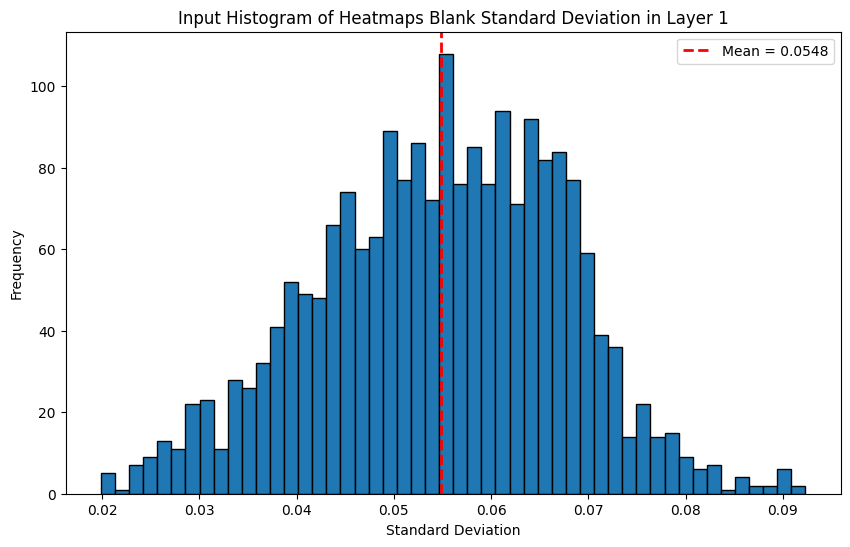

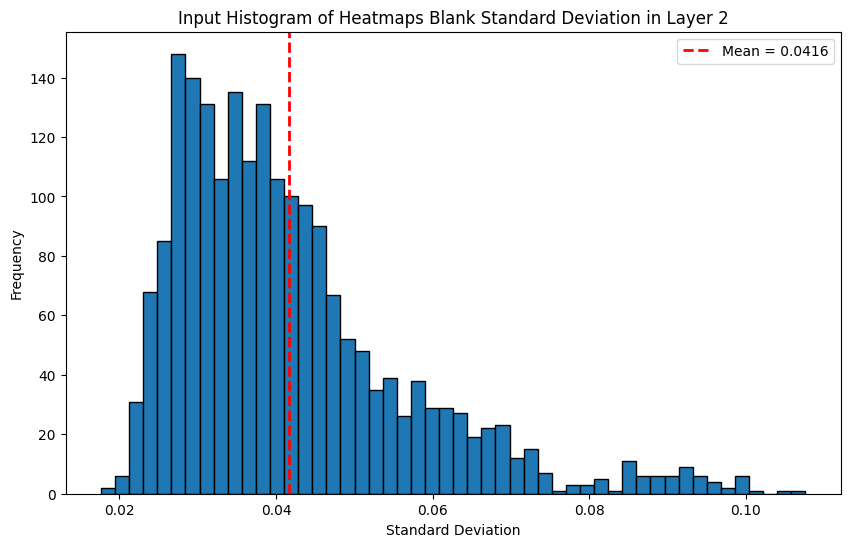

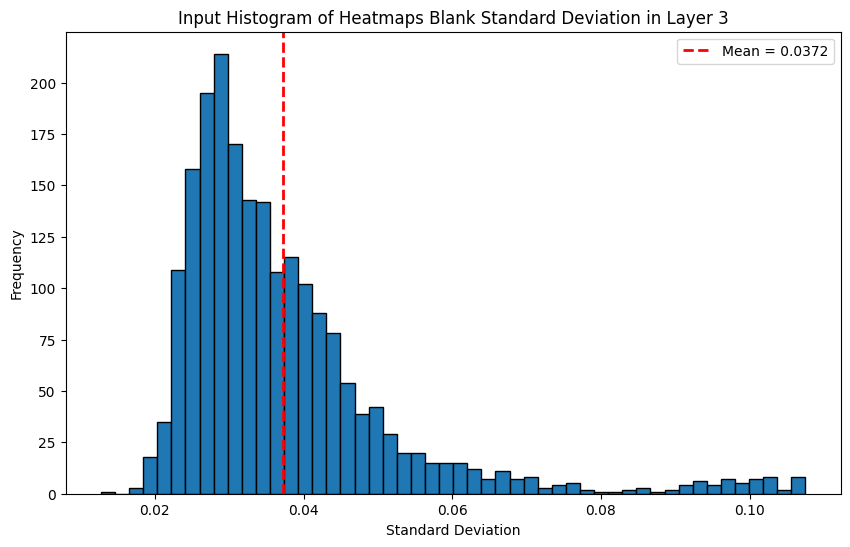

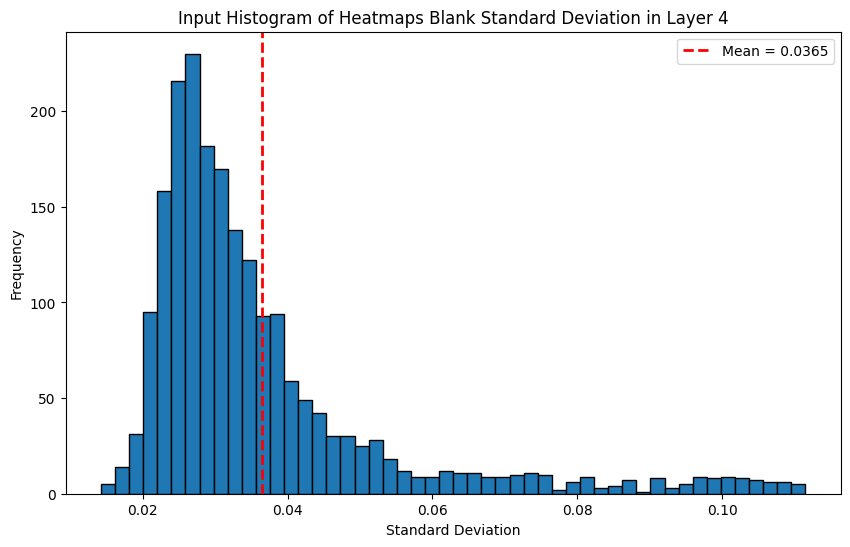

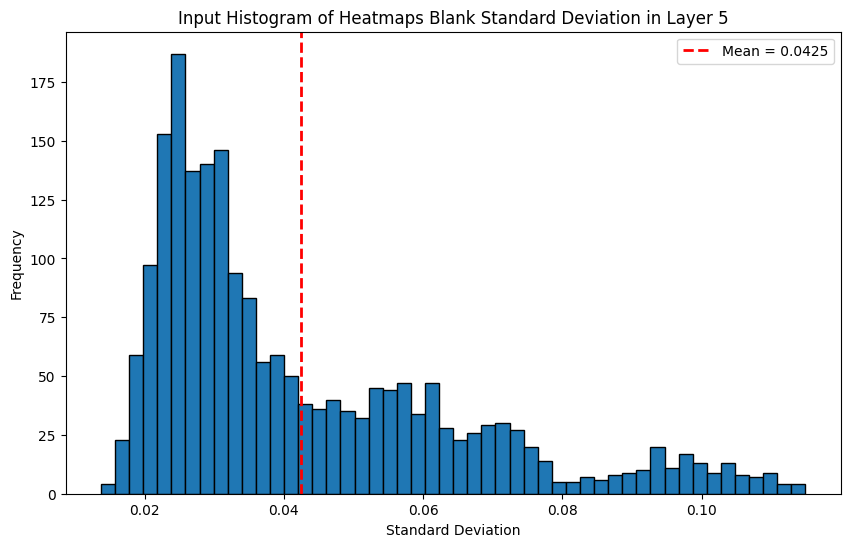

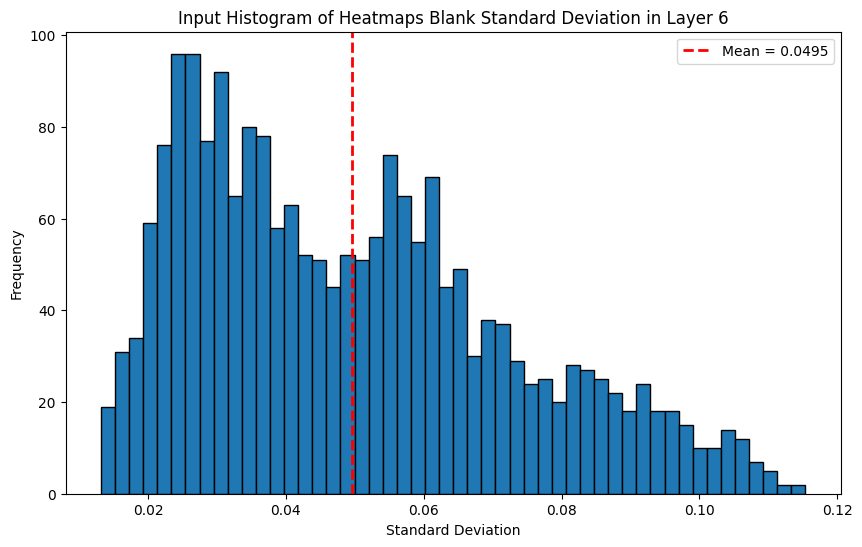

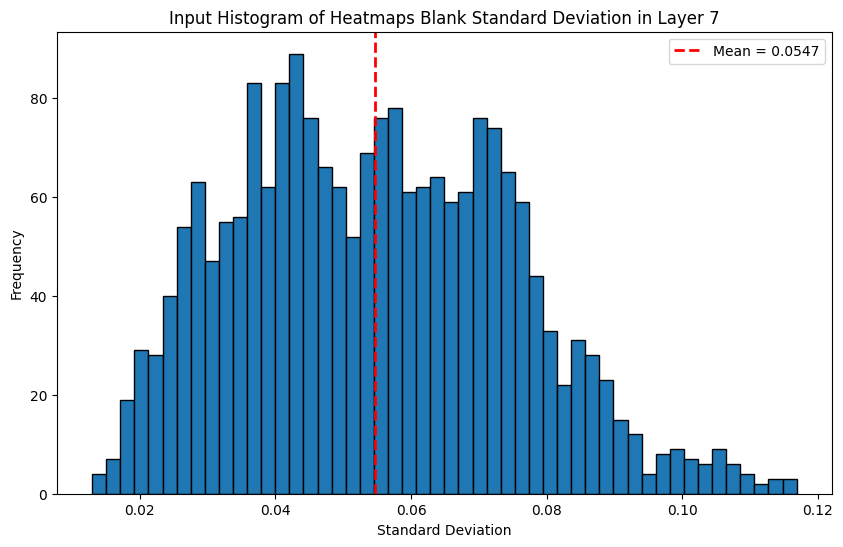

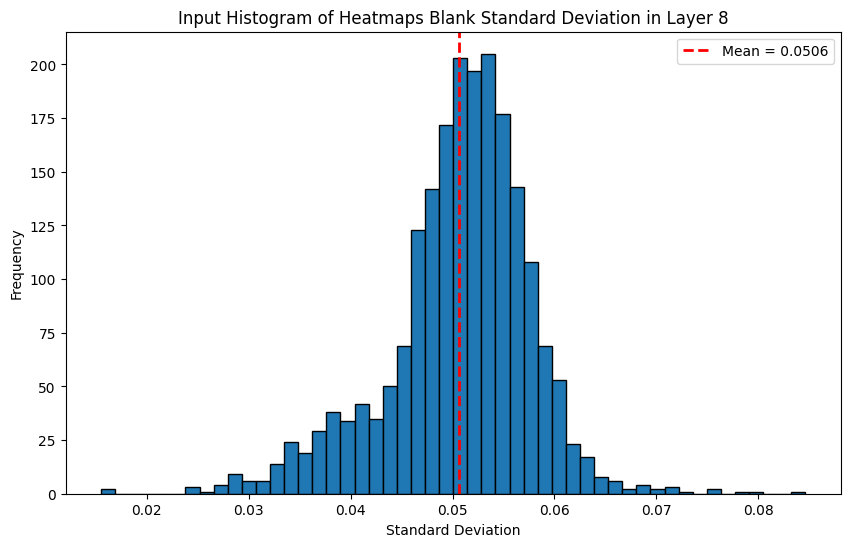

In [ ]:
# Tweaking
import matplotlib.pyplot as plt
layers = list(range(0,8))
for layer in layers:
    heatmaps_blank = []
    heatmaps_my = []
    for neuron in range(0, 2048):
        w_out = model.blocks[layer].mlp.W_in[:, neuron].detach()
        w_out /= w_out.norm()
        heatmaps_blank.append((w_out[:, None, None] * blank_probe_normalised).sum(dim=0))
        heatmaps_my.append((w_out[:, None, None] * my_probe_normalised).sum(dim=0))
        
    heatmaps_blank = torch.stack(heatmaps_blank)
    heatmaps_my = torch.stack(heatmaps_my)
    
    if True:
        heatmaps_blank_std = heatmaps_blank.std(dim=[1, 2])
        mean_value = heatmaps_blank_std.mean().item()

        plt.figure(figsize=(10, 6))
        plt.hist(heatmaps_blank_std.detach().cpu().numpy(), bins=50, edgecolor='black')
        plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_value:.4f}')
        plt.title(f"Input Histogram of Heatmaps Blank Standard Deviation in Layer {layer+1}")
        plt.xlabel("Standard Deviation")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()
    else:
        heatmaps_my_std = heatmaps_my.std(dim=[1, 2])
        mean_value = heatmaps_my_std.mean().item()
        plt.figure(figsize=(10, 6))
        plt.hist(heatmaps_my_std.detach().cpu().numpy(), bins=50, edgecolor='black')
        plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_value:.4f}')
        plt.title(f"Input Histogram of Heatmaps My Standard Deviation in Layer {layer+1}")
        plt.xlabel("Standard Deviation")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()



### Observe specific position

In [117]:
# Tweaking
layer = 3
heatmaps_blank = []
heatmaps_my = []
for neuron in range(0, 2048):
    w_out = model.blocks[layer].mlp.W_in[:, neuron].detach()
    w_out /= w_out.norm()
    heatmaps_blank.append((w_out[:, None, None] * blank_probe_normalised).sum(dim=0))
    heatmaps_my.append((w_out[:, None, None] * my_probe_normalised).sum(dim=0))
    # state = torch.zeros(64, device="cuda")
    # state[stoi_indices] = w_out @ model.W_U[:, 1:]
    # heatmaps.append(state.reshape(8, 8))
heatmaps_blank = torch.stack(heatmaps_blank)
heatmaps_my = torch.stack(heatmaps_my)
# heatmaps_blank_id = heatmaps_blank.std(dim=[1, 2]).argsort(descending=True)[:10]
heatmaps_blank_id = torch.abs(heatmaps_blank[:, 1, 2]).argsort(descending=True)[:10] # (2, 3)
heatmaps_blank = heatmaps_blank[heatmaps_blank_id]
# heatmaps_my_id = heatmaps_my.std(dim=[1, 2]).argsort(descending=True)[:10]
heatmaps_my_id = torch.abs(heatmaps_my[:, 1, 2]).argsort(descending=True)[:10]
heatmaps_my = heatmaps_my[heatmaps_my_id]

imshow(heatmaps_blank,
    facet_col=0,
    y=[i for i in "ABCDEFGH"],
    title=f"Cosine sim of Output weights and the blank color probe for top layer {layer} neurons",
    facet_labels=[f"L4N{n.item()}" for n in heatmaps_blank_id])
imshow(heatmaps_my,
    facet_col=0,
    y=[i for i in "ABCDEFGH"],
    title=f"Cosine sim of Output weights and the my color probe for top layer {layer} neurons",
    facet_labels=[f"L4N{n.item()}" for n in heatmaps_my_id])

### Mask Based observations

In [ ]:
# Tweaking
layer = 2
layers = list(range(0,8))
for layer in layers:
    vertical_mask = torch.zeros(8, 8).to("cuda"); vertical_mask[:, 0] = 1; vertical_mask = vertical_mask.unsqueeze(0)
    diagonal_mask = torch.eye(8, 8).to("cuda"); diagonal_mask = diagonal_mask.unsqueeze(0)
    heatmaps_blank = []
    heatmaps_my = []
    for neuron in range(0, 2048):
        w_out = model.blocks[layer].mlp.W_in[:, neuron].detach()
        w_out /= w_out.norm()
        heatmaps_blank.append((w_out[:, None, None] * blank_probe_normalised).sum(dim=0))
        heatmaps_my.append((w_out[:, None, None] * my_probe_normalised).sum(dim=0))
        # state = torch.zeros(64, device="cuda")
        # state[stoi_indices] = w_out @ model.W_U[:, 1:]
        # heatmaps.append(state.reshape(8, 8))

    heatmaps_blank = torch.stack(heatmaps_blank)
    heatmaps_blank_mask = heatmaps_blank * vertical_mask
    heatmaps_my = torch.stack(heatmaps_my)
    heatmaps_my_mask = heatmaps_my * vertical_mask
    heatmaps_blank_id = torch.abs(heatmaps_blank_mask).sum(dim=[1, 2]).argsort(descending=True)[:10]
    heatmaps_blank = heatmaps_blank[heatmaps_blank_id]
    heatmaps_my_id = torch.abs(heatmaps_my_mask).sum(dim=[1, 2]).argsort(descending=True)[:10]
    heatmaps_my = heatmaps_my[heatmaps_my_id]

    imshow(heatmaps_blank,
        facet_col=0,
        y=[i for i in "ABCDEFGH"],
        title=f"Cosine sim of Output weights and the blank color probe for top layer {layer} neurons",
        facet_labels=[f"L4N{n.item()}" for n in heatmaps_blank_id])
    imshow(heatmaps_my,
        facet_col=0,
        y=[i for i in "ABCDEFGH"],
        title=f"Cosine sim of Output weights and the my color probe for top layer {layer} neurons",
        facet_labels=[f"L4N{n.item()}" for n in heatmaps_my_id])

Why is the blank output weights of the layer 4 neurons so striking?!

It's because blank probe is actually highly aligned with the unembed weights - a cell can *only* be legal to play in if it is blank (obviously). Since calculating blankness is easy (you just check whether a move was played), the model should be able to do this in a single layer. But our probe was computed after layer 6, when there's a lot of extraneous information - probably, the probe also learned that if there's going to be a high logit for a cell then that cell is definitely blank, and so the blank directions are partially aligned with the unembed directions.

Let's look at the cosine sim of those neurons and the unembed directions:

In [45]:
layer = 4
top_layer_4_neurons = focus_cache["post", layer][:, 3:-3].std(dim=[0, 1]).argsort(descending=True)[:10]
W_U_norm = model.W_U / model.W_U.norm(dim=0, keepdim=True)
W_U_norm = W_U_norm[:, 1:] # Get rid of the passing/dummy first element
heatmaps_unembed = []
for neuron in top_layer_4_neurons:
    neuron = neuron.item()
    w_out = model.blocks[layer].mlp.W_out[neuron, :].detach()
    w_out /= w_out.norm()
    state = torch.zeros(64, device="cuda")
    state[stoi_indices] = w_out @ W_U_norm
    heatmaps_unembed.append(state.reshape(8, 8))
imshow(heatmaps_unembed,
    facet_col=0,
    y=[i for i in "ABCDEFGH"],
    title=f"Cosine sim of Output weights and the unembed for top layer 4 neurons",
    facet_labels=[f"L4N{n.item()}" for n in top_layer_4_neurons])

## Activation Patching

A valuable technique for tracking down the action of various circuits is activation patching. Check out https://neelnanda.io/exploratory-analysis-demo for more details, but here's a quick demo of using it on Othello.

The key idea is to set up a clean and corrupted input that differ in one key detail, and to **patch** a single clean activation into the corrupted run (ie replacing that activation with its value on the clean run, eg the output of an attention head), and to look at this patch's effect on a metric that depends on that detail. By carefully choosing clean and corrupted inputs that differ in one key detail, we can isolate which model components capture and depend on this detail.

Setting up clean and corrupted moves tha tresult in similar games is non-trivial, so here we take a game and just change the most recent move from E0 to C0. This turns F0 from legal to illegal, so let's make that logit our patching metric

In [46]:
game_index = 4
move = 20
plot_single_board(focus_games_string[game_index, :move+1], title="Original Game (black plays E0)")
plot_single_board(focus_games_string[game_index, :move].tolist()+[16], title="Corrupted Game (blank plays C0)")

In [47]:
clean_input = focus_games_int[game_index, :move+1].clone()
corrupted_input = focus_games_int[game_index, :move+1].clone()
corrupted_input[-1] = to_int("C0")
print("Clean", int_to_label(corrupted_input))
print("Corrupted", int_to_label(clean_input))

Clean ['C3', 'C4', 'C5', 'E2', 'F2', 'C2', 'D2', 'E1', 'F5', 'B6', 'C6', 'B5', 'C1', 'B0', 'B4', 'E5', 'F6', 'B2', 'F4', 'B3', 'C0']
Corrupted ['C3', 'C4', 'C5', 'E2', 'F2', 'C2', 'D2', 'E1', 'F5', 'B6', 'C6', 'B5', 'C1', 'B0', 'B4', 'E5', 'F6', 'B2', 'F4', 'B3', 'E0']


In [48]:
clean_logits, clean_cache = model.run_with_cache(clean_input)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_input)

clean_log_probs = clean_logits.log_softmax(dim=-1)
corrupted_log_probs = corrupted_logits.log_softmax(dim=-1)

Let's patch in each attention layer in turn and analyse the effect on the logit of F0

In [49]:
f0_index = to_int("F0")
clean_f0_log_prob = clean_log_probs[0, -1, f0_index]
corrupted_f0_log_prob = corrupted_log_probs[0, -1, f0_index]
print("Clean log prob", clean_f0_log_prob)
print("Corrupted log prob", corrupted_f0_log_prob)

def patching_metric(patched_logits):
    # patched_log_probs.shape is [1, 21, 61]
    patched_log_probs = patched_logits.log_softmax(dim=-1)
    return (patched_log_probs[0, -1, f0_index] - corrupted_f0_log_prob)/(clean_f0_log_prob - corrupted_f0_log_prob)
print("Clean metric", patching_metric(clean_logits))
print("Corrupted metric", patching_metric(corrupted_logits))

Clean log prob tensor(-2.5273, device='cuda:0', grad_fn=<SelectBackward0>)
Corrupted log prob tensor(-12.0080, device='cuda:0', grad_fn=<SelectBackward0>)
Clean metric tensor(1., device='cuda:0', grad_fn=<DivBackward0>)
Corrupted metric tensor(0., device='cuda:0', grad_fn=<DivBackward0>)


In [50]:
attn_layer_patches = []
def patch_attn_layer_output(attn_out, hook, layer):
    # Only patch in on the final move, prior moves are identical
    attn_out[0, -1, :] = clean_cache["attn_out", layer][0, -1, :]
    return attn_out
for layer in range(8):
    patched_logits = model.run_with_hooks(corrupted_input, fwd_hooks=[(utils.get_act_name("attn_out", layer), partial(patch_attn_layer_output, layer=layer))])
    attn_layer_patches.append(patching_metric(patched_logits).item())

mlp_layer_patches = []
def patch_mlp_layer_output(mlp_out, hook, layer):
    # Only patch in on the final move, prior moves are identical
    mlp_out[0, -1, :] = clean_cache["mlp_out", layer][0, -1, :]
    return mlp_out
for layer in range(8):
    patched_logits = model.run_with_hooks(corrupted_input, fwd_hooks=[(utils.get_act_name("mlp_out", layer), partial(patch_mlp_layer_output, layer=layer))])
    mlp_layer_patches.append(patching_metric(patched_logits).item())
line([attn_layer_patches, mlp_layer_patches], title="Layer Output Patching Effect on F0 Log Prob", line_labels=["attn", "mlp"])

We can see that most layers just don't matter! But MLP0, MLP5, MLP6 and Attn7 do! My next steps would be to get more fine grained and to patch in individual neurons and see how far I can zoom in on *why* those layers matter - ideally at the level of understanding how these neurons compose with each other and the changed the embedding, using the fact that most of the model just doesn't matter here. And then to compare this data to the above techniques for understanding neurons.

It's not surprising that the attention layers are fairly unimportant - attention specialises in moving information between token positions, we've only changed the information at the current position!

## Analysing Neuron L5N1393

To practice neuron interpretability, let's take a deep dive into understanding this neuron - the techniques and code should transfer pretty well to any other neurons!

The spirit of this section is to practice doing various standard things that you could go and apply to another neuron in practice - I end it still being fairly confused, and with many dangling threads!

As above, we can use the probe weights to analyse its input weights. So we go in with the hypothesis that it detects C0==BLANK & D1==THEIR'S & E2==MINE, and that it directly boosts the C0 logit - this configuration means that C0 must be legal, because it'd flank D1 along the diagonal!

We can also take the direct logit attribution of its output weights - ie w_out @ W_U, to see if the neuron significantly affects the output logits directly.

Note that this is purely weights based analysis, we have not yet run the model and looked at any activations!

Here we immediately see that boosting C0 is an important part of what happens, but that it also boosts D1, which is surprising! (D1 is filled in our hypothesis, so must be illegal!)

In [51]:
layer = 5
neuron = 1393
w_out = model.blocks[layer].mlp.W_out[neuron, :]
state = torch.zeros(8, 8, device="cuda")
state.flatten()[stoi_indices] = w_out @ model.W_U[:, 1:]
plot_square_as_board(state, title=f"Output weights of Neuron L{layer}N{neuron} in the output logit basis", width=600)

One hypothesis is that the unembed for C0 and D1 are highly aligned, so it can't easily boost one but not the other. But this is false, they're almost orthogonal

In [52]:
c0_U = model.W_U[:, 17].detach()
c0_U /= c0_U.norm()
d1_U = model.W_U[:, 26].detach()
d1_U /= d1_U.norm()
print("Cosine sim of C0 and D1 unembeds", c0_U @ d1_U)

Cosine sim of C0 and D1 unembeds tensor(-0.0221, device='cuda:0')


To check that this is a *big* part of the neuron's output, lets look at the fraction of variance of the output captured by the W_U subspace - we see that it's only 28.6%, so something else is probably going on too! (Maybe some dropout related backup circuits? Or just assisting in further processing)

In [53]:
# Remove the 0th element, which never comes up
U, S, Vh = torch.svd(model.W_U[:, 1:])
print("Fraction of variance captured by W_U", (w_out @ U).norm().item()**2)

Fraction of variance captured by W_U 0.2868000746805741


Another quick sanity check is just plotting what the neuron activations look like over the 50 games in our cache - we see that it only matters in a few games, and matters every other move (which makes sense for a feature denominated in terms of my vs their colours - this alternates every move as the colours swap!)

In [54]:
neuron_acts = focus_cache["post", layer, "mlp"][:, :, neuron]
imshow(neuron_acts, title=f"L{layer}N{neuron} Activations over 50 games", yaxis="Game", xaxis="Move")

### Max Activating Dataset Examples

Another tactic is studying the max activating dataset examples for the neuron. Doing this properly across many games is effort, but here we have cached outputs on 50 games (3000 moves), so we can look at the top 30 games there. This is hard to look at individually, so we can aggregate according to how often each cell is mine vs their's (setting their's==1, mine==-1 and blank==0, and averaging)

In [55]:
# focus_states_flipped_value does this but has their's==2 and mine==1, not 1 and -1. So let's convert, this is boring and you don't need to understand it.
focus_states_flipped_pm1 = torch.zeros_like(focus_states_flipped_value, device="cuda")
focus_states_flipped_pm1[focus_states_flipped_value==2] = 1.
focus_states_flipped_pm1[focus_states_flipped_value==1] = -1.



In [56]:
# This involves a lot of fucky tensor manipulation, no need to follow closely
top_moves = neuron_acts.flatten() > neuron_acts.flatten().quantile(0.99)
plot_square_as_board(focus_states_flipped_pm1[:, :-1].reshape(-1, 64)[top_moves].float().mean(0).reshape(8, 8), title=f"Aggregated top 30 moves for neuron L{layer}N{neuron}", width=600)

We can try the same thing for the top 10 neurons in layer 5 (by std)

In [57]:
top_neurons = focus_cache["post", 5, "mlp"].std(dim=[0, 1]).argsort(descending=True)[:10]
heatmaps = []
for neuron in top_neurons:
    neuron = neuron.item()
    neuron_acts = focus_cache["post", 5, "mlp"][:, :, neuron]
    top_moves = neuron_acts.flatten() > neuron_acts.flatten().quantile(0.99)
    heatmaps.append(focus_states_flipped_pm1[:, :-1].reshape(-1, 64)[top_moves].float().mean(0).reshape(8, 8))
plot_square_as_board(heatmaps, title=f"Aggregated top 30 moves for each top 10 neuron in layer 5",facet_col=0, facet_labels=[f"L5N{n.item()}" for n in top_neurons])

We can also try layer 4, but this time let's look at the fraction of the time a cell is blank vs not blank (regardless of the colour) - we some neurons that strikingly only activate when certain cells are blank (and the neighbours are often not blank, showing it's not just eg the neuron activates in the early game when most cells are blank).

Layer 4 is late enough that it's probably using the "is blank" feature rather than computing it, and I'm curious what these do!

In [58]:
top_neurons = focus_cache["post", 4, "mlp"].std(dim=[0, 1]).argsort(descending=True)[:10]
heatmaps = []
for neuron in top_neurons:
    neuron = neuron.item()
    neuron_acts = focus_cache["post", 4, "mlp"][:, :, neuron]
    top_moves = neuron_acts.flatten() > neuron_acts.flatten().quantile(0.99)
    heatmaps.append(focus_states_flipped_pm1[:, :-1].abs().reshape(-1, 64)[top_moves].float().mean(0).reshape(8, 8))
plot_square_as_board(heatmaps, title=f"Aggregated top 40 moves for each top 10 neuron in layer 4",facet_col=0, facet_labels=[f"L4N{n.item()}" for n in top_neurons])

### Spectrum Plots

One of the best ways to validate a hypothesis about neurons is to use a **spectrum plot**, where we plot a histogram of the neuron activations across the full data distribution (or at least some random sample) and categorise each activation by whether it has the property we think the neuron is detecting. We can do a janky version of that with the neuron's activations on our 50 games (plotting each histogram group as percent of the group size, to normalise for most games not having the configuration hypothesised)

Fascinatingly, we see that our hypothesis did *not* fully capture the neuron - almost every high activation had the hypothesised configuration, but so did some low ones! I'm not sure what's going on here, but it reveals a weakness of max activating dataset examples - they don't let you notice when your hypothesis allows false positives!

**Exercise**: Look at the moves with this configuration and low activations - what's going on there? Can you see any patterns in the board states? In the moves? What does the neuron activation look like over the course of the game?

In [59]:

c0 = focus_states_flipped_pm1[:, :, 2, 0]
d1 = focus_states_flipped_pm1[:, :, 3, 1]
e2 = focus_states_flipped_pm1[:, :, 4, 2]

label = (c0==0) & (d1==-1) & (e2==1)

import pandas as pd
neuron_acts = focus_cache["post", 5][:, :, 1393]
df = pd.DataFrame({"acts":neuron_acts.flatten().tolist(), "label":label[:, :-1].flatten().tolist()})
px.histogram(df, x="acts", color="label", histnorm="percent", nbins=100, title="Spectrum plot for neuron L5N1393 testing C0==BLANK & D1==THEIR'S & E2==MINE")
# %%


## Making Figure 1

In [60]:
layer = 6
game_index = 1
for move in [20, 21, 22]:
    def plot_probe_outputs_figure(layer, game_index, move, **kwargs):
        residual_stream = focus_cache["resid_post", layer][game_index, move]
        print("residual_stream", residual_stream.shape)
        probe_out = einops.einsum(residual_stream, linear_probe, "d_model, d_model row col options -> row col options")
        probabilities = probe_out.softmax(dim=-1)
        fig = imshow(probabilities, facet_col=2, facet_labels=["P(Empty)", "P(Their Colour)", "P(My Colour)"], height=300, width=600, return_fig=True)
        fig.update_layout(xaxis_visible=False, yaxis_visible=False, xaxis2_visible=False, xaxis3_visible=False, coloraxis_showscale=False)
        fig.show()
    plot_probe_outputs_figure(layer, game_index, move)

    fig = plot_single_board(int_to_label(focus_games_int[game_index, :move+1]), return_fig=True)
    fig.update_layout(xaxis_visible=False, yaxis_visible=False, coloraxis_showscale=False, height=400)
    fig.show()


residual_stream torch.Size([512])


residual_stream torch.Size([512])


residual_stream torch.Size([512])


In [61]:
" ".join(int_to_label(focus_games_int[game_index, :move+1]))

'F4 F3 D2 F5 G2 F2 G3 C4 E5 F6 D6 E2 B4 C5 G7 C1 G6 F7 G5 C3 B3 H6 G4'